# 사용할 패키지

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Conv3D, ConvLSTM2D, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam

# TPU 장치 설정

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  
    # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 
    # default distribution strategy in Tensorflow. Works on CPU and single GPU.
print("REPLICAS: ", strategy.num_replicas_in_sync)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/'

# 데이터 가져오기

In [ ]:
train_csv = pd.read_csv(path+'train.csv')

In [ ]:
train_csv.head(30)

전체 데이터중 최근 30년 데이터만 학습에 사용하였습니다.

In [ ]:
train_path = sorted(glob('/content/drive/MyDrive/train/*.npy'))
train_path = train_path[-31*12:-12]

In [ ]:
train = []
for p in tqdm(train_path):
    train.append(np.load(p))
train = np.array(train)

100%|██████████| 360/360 [01:16<00:00,  4.72it/s]


In [ ]:
train.shape

(360, 448, 304, 5)

# 데이터 시각화

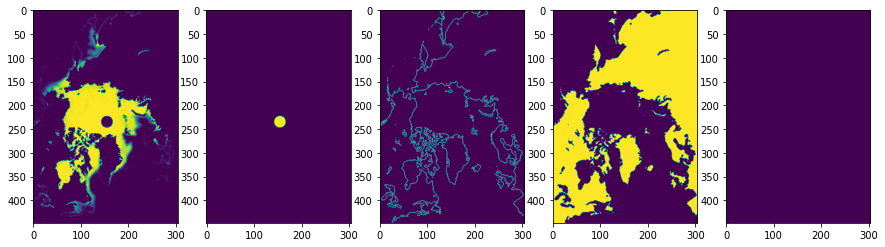

In [ ]:
plt.figure(figsize=(15,10))
plt.subplot(151)
plt.imshow(train[0,:,:,0])
plt.subplot(152)
plt.imshow(train[0,:,:,1])
plt.subplot(153)
plt.imshow(train[0,:,:,2])
plt.subplot(154)
plt.imshow(train[0,:,:,3])
plt.subplot(155)
plt.imshow(train[0,:,:,4])

In [ ]:
missings = pd.DataFrame()

for k in range(360) : 
  missings = pd.concat([missings,pd.DataFrame(train[k,:,:,4].reshape(-1,1))],ignore_index=True)

print(missings.min().min())
print(missings.max().max())

0
0


In [ ]:
train[0,:,:,0] + train[0,:,:,1]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [ ]:
for k in range(360) :

  new_array = train[k,:,:,0] + train[k,:,:,1]*250
  train[k,:,:,0] = new_array

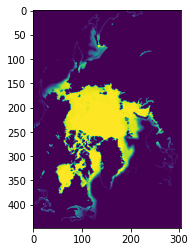

In [ ]:
plt.imshow(train[0,:,:,0])

# 월별 데이터로 분리

In [ ]:
train_month = []
for i in range(12):
    train_month.append(train[i::12, :,:,:])
train_month = np.array(train_month)

In [ ]:
train_month.shape

(12, 30, 448, 304, 5)

# 이미지를 잘랐을 때 사이즈가 같도록 패딩

In [ ]:
stride = 32
temp = np.zeros([train_month.shape[0],
                 train_month.shape[1],
                 train_month.shape[2]+(stride-train_month.shape[2]%stride),
                 train_month.shape[3]+(stride-train_month.shape[3]%stride),
                 train_month.shape[4]], np.uint8)
temp[:, :,:train_month.shape[2], :train_month.shape[3], :] = train_month
train_month = temp
del temp

In [ ]:
train_month.shape

(12, 30, 480, 320, 5)

# 5년 단위로 데이터 전처리

In [ ]:
window_size = 5

In [ ]:
x_train = []
y_train = []

for i in range(train_month.shape[1]-window_size):
    x_train.append(train_month[:, i:i+window_size, :,:,:])
    y_train.append(train_month[:, i+window_size:i+window_size+1, :,:,:])
    
x_train = np.array(x_train)
y_train = np.array(y_train)

In [ ]:
x_train.shape, y_train.shape

((25, 12, 5, 480, 320, 5), (25, 12, 1, 480, 320, 5))

# 시각화

특정 월의 5년간 변화와 그 다음 상태

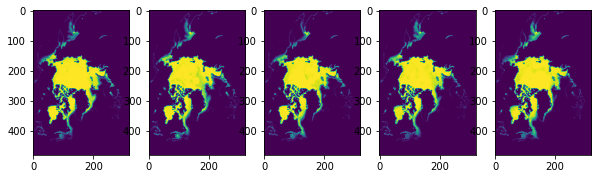

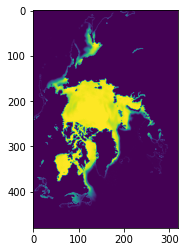

In [ ]:
m = 1
plt.figure(figsize=(10,15))
for y in range(x_train.shape[2]):
    plt.subplot(1,window_size,y+1)
    plt.imshow(x_train[0,m-1,y,:,:,0])
plt.show()

plt.imshow(y_train[0,m-1,-1,:,:,0])

# 데이터 자르기

이미지가 클 경우 ConvLSTM모델의 메모리가 부족하여 가로세로 32px씩 이동하며 128x128로 이미지를 잘랐습니다.

학습에는 2018년까지, 2018년도를 평가 데이터로 활용하여 학습 결과를 2018년(가장 최근년도)에 과적합시켰습니다.

In [ ]:
stride = 32
feature_size = 128

x_train_ = []
y_train_ = []

for y in range(20):
    for m in range(12):
        for i in range((x_train.shape[3]-feature_size)//stride+1):
            for j in range((x_train.shape[4]-feature_size)//stride+1):
                x_ = x_train[y, m, :, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size,:1]  
                y_ = y_train[y, m, :, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size,:1] 
                x_train_.append(x_)
                y_train_.append(y_)

x_train_ = np.array(x_train_)
y_train_ = np.array(y_train_)

x_val_ = []
y_val_ = []

for y in range(20,24):
  for m in range(12):
      for i in range((x_train.shape[3]-feature_size)//stride+1):
          for j in range((x_train.shape[4]-feature_size)//stride+1):
              x_ = x_train[y, m, :, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, :1]
              y_ = y_train[y, m, :, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, :1]
              x_val_.append(x_)
              y_val_.append(y_)

x_val_ = np.array(x_val_)
y_val_ = np.array(y_val_)

x_test_ = []
y_test_ = []

for y in range(24,25):
  for m in range(12):
      for i in range((x_train.shape[3]-feature_size)//stride+1):
          for j in range((x_train.shape[4]-feature_size)//stride+1):
              x_ = x_train[y, m, :, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, :1]
              y_ = y_train[y, m, :, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, :1]
              x_test_.append(x_)
              y_test_.append(y_)

x_test_ = np.array(x_test_)
y_test_ = np.array(y_test_)

In [ ]:
x_train_.shape, y_train_.shape, x_val_.shape, y_val_.shape, x_test_.shape, y_test_.shape

((20160, 5, 128, 128, 1),
 (20160, 1, 128, 128, 1),
 (4032, 5, 128, 128, 1),
 (4032, 1, 128, 128, 1),
 (1008, 5, 128, 128, 1),
 (1008, 1, 128, 128, 1))

# 데이터 시각화

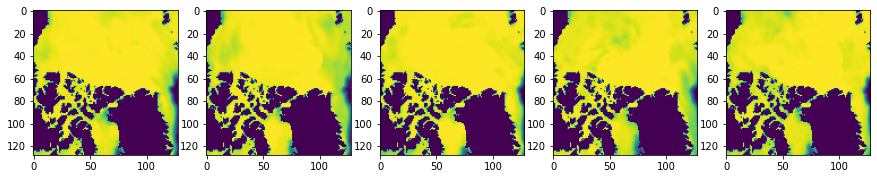

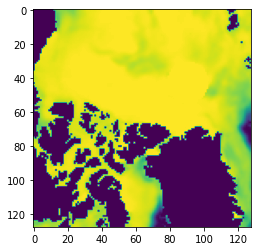

In [ ]:
i = 5000
plt.figure(figsize=(15,10))
for y in range(x_train_.shape[1]):
    plt.subplot(1,window_size,y+1)
    plt.imshow(x_train_[i,y,:,:,0])
plt.show()
plt.imshow(y_train_[i,-1,:,:,0])

# 데이터셋

In [ ]:
def train_map_func(x, y):
    x = tf.cast(x, tf.float32)/250
    y = tf.cast(y, tf.float32)
    return x, y

In [ ]:
BATCH_SIZE = 32

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_, y_train_))
train_dataset = train_dataset.map(train_map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val_, y_val_))
val_dataset = val_dataset.map(train_map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test_, y_test_))
test_dataset = test_dataset.map(train_map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [ ]:
next(iter(train_dataset))[0].shape, next(iter(train_dataset))[1].shape

(TensorShape([32, 5, 128, 128, 1]), TensorShape([32, 1, 128, 128, 1]))

In [ ]:
next(iter(val_dataset))[0].shape, next(iter(val_dataset))[1].shape

(TensorShape([32, 5, 128, 128, 1]), TensorShape([32, 1, 128, 128, 1]))

In [ ]:
np.array(train_dataset)

array(<PrefetchDataset shapes: ((None, 5, 128, 128, 1), (None, 1, 128, 128, 1)), types: (tf.float32, tf.float32)>,
      dtype=object)

# 모델

keras를 이용해 간단한 ConvLSTM 모델을 만들었습니다.

메모리가 많이 필요하여 colab TPU 사용을 권장드립니다.

In [ ]:
from tensorflow import keras

In [ ]:
[name for name in dir(keras.layers) if not name.startswith("_")]

['AbstractRNNCell',
 'Activation',
 'ActivityRegularization',
 'Add',
 'AdditiveAttention',
 'AlphaDropout',
 'Attention',
 'Average',
 'AveragePooling1D',
 'AveragePooling2D',
 'AveragePooling3D',
 'AvgPool1D',
 'AvgPool2D',
 'AvgPool3D',
 'BatchNormalization',
 'Bidirectional',
 'Concatenate',
 'Conv1D',
 'Conv1DTranspose',
 'Conv2D',
 'Conv2DTranspose',
 'Conv3D',
 'Conv3DTranspose',
 'ConvLSTM2D',
 'Convolution1D',
 'Convolution1DTranspose',
 'Convolution2D',
 'Convolution2DTranspose',
 'Convolution3D',
 'Convolution3DTranspose',
 'Cropping1D',
 'Cropping2D',
 'Cropping3D',
 'Dense',
 'DenseFeatures',
 'DepthwiseConv2D',
 'Dot',
 'Dropout',
 'ELU',
 'Embedding',
 'Flatten',
 'GRU',
 'GRUCell',
 'GaussianDropout',
 'GaussianNoise',
 'GlobalAveragePooling1D',
 'GlobalAveragePooling2D',
 'GlobalAveragePooling3D',
 'GlobalAvgPool1D',
 'GlobalAvgPool2D',
 'GlobalAvgPool3D',
 'GlobalMaxPool1D',
 'GlobalMaxPool2D',
 'GlobalMaxPool3D',
 'GlobalMaxPooling1D',
 'GlobalMaxPooling2D',
 'Global

In [ ]:
with strategy.scope():
    inputs=Input((None, x_train_.shape[2], x_train_.shape[3], 1))

    convLSTM = ConvLSTM2D(filters=64, kernel_size=3, padding='same', return_sequences=True)(inputs)
    convLSTM = BatchNormalization()(convLSTM)

    convLSTM = ConvLSTM2D(filters=64, kernel_size=3, padding='same', return_sequences=True)(convLSTM)
    convLSTM = BatchNormalization()(convLSTM)

    convLSTM = ConvLSTM2D(filters=64, kernel_size=3, padding='same', return_sequences=True)(convLSTM)
    convLSTM = BatchNormalization()(convLSTM)

    outputs = Conv3D(filters=1, kernel_size=3, activation='relu', padding='same', data_format='channels_last')(convLSTM)

    model1 = Model(inputs, outputs)
    model1.compile(loss='mae', optimizer=RMSProp())
    
model1.summary() 

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 128, 128, 1 0         
_________________________________________________________________
conv_lst_m2d (ConvLSTM2D)    (None, None, 128, 128, 64 150016    
_________________________________________________________________
batch_normalization (BatchNo (None, None, 128, 128, 64 256       
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, None, 128, 128, 64 295168    
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 128, 128, 64 256       
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, None, 128, 128, 64 295168    
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 128, 128, 64 256   

# 학습

20epochs까지만 학습하였습니다.

In [ ]:
if not (os.path.isdir('models')):
    os.makedirs('models')

callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath = './models/convlstm_model.h5',
        monitor='val_loss',
        save_best_only=True
    )
]

hist1 = model1.fit(train_dataset, epochs=20, validation_data=val_dataset, callbacks=callbacks_list)

Epoch 1/20
630/630 [==============================] - 327s 479ms/step - loss: 20.7153 - val_loss: 7.4967
Epoch 2/20
630/630 [==============================] - 285s 453ms/step - loss: 8.3850 - val_loss: 7.2078
Epoch 3/20
630/630 [==============================] - 285s 453ms/step - loss: 7.6178 - val_loss: 7.7346
Epoch 4/20
630/630 [==============================] - 285s 453ms/step - loss: 6.9655 - val_loss: 7.6123
Epoch 5/20
630/630 [==============================] - 285s 453ms/step - loss: 6.2629 - val_loss: 6.9139
Epoch 6/20
630/630 [==============================] - 285s 453ms/step - loss: 5.9628 - val_loss: 7.1874
Epoch 7/20
630/630 [==============================] - 285s 453ms/step - loss: 5.8299 - val_loss: 6.7791
Epoch 8/20
630/630 [==============================] - 285s 453ms/step - loss: 5.6745 - val_loss: 6.5533
Epoch 9/20
630/630 [==============================] - 285s 453ms/step - loss: 5.6633 - val_loss: 6.2932
Epoch 10/20
630/630 [==============================] - 285s 453

# 학습 결과

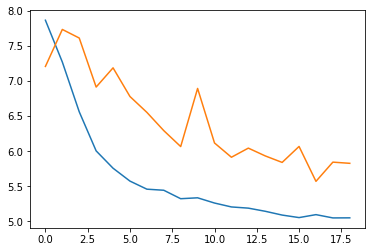

In [ ]:
plt.plot(hist1.history['loss'][1:])
plt.plot(hist1.history['val_loss'][1:])
plt.show()

# 모델 불러오기

In [ ]:
model = load_model('/content/models/convlstm_model.h5')

# 검증셋 추론

In [ ]:
pred = model.predict(next(iter(val_dataset))[0])
pred = np.where(pred>250, 250, pred)

In [ ]:
pred.shape

(32, 5, 128, 128, 1)

## 검증셋 추론 결과

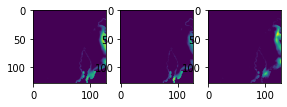

3.5122542


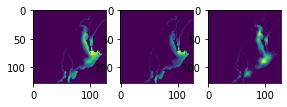

5.786684


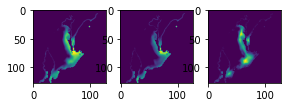

5.811016


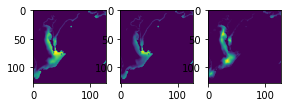

5.788865


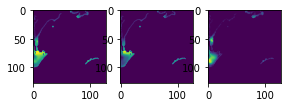

2.5561206


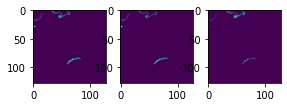

0.35393706


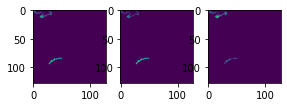

0.32703575


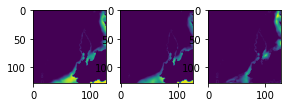

4.735007


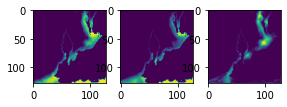

7.0191393


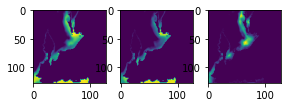

6.5203066


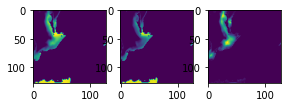

5.392354


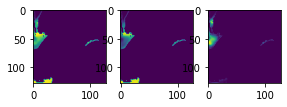

2.3125591


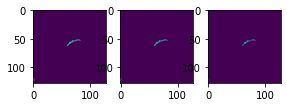

0.09538455


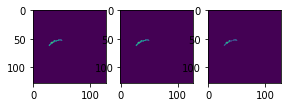

0.07200548


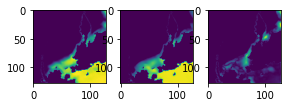

4.7102685


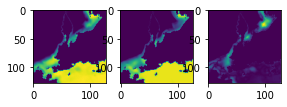

6.589425


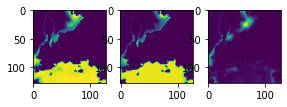

5.9957848


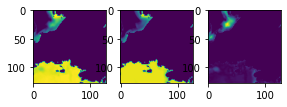

4.4792347


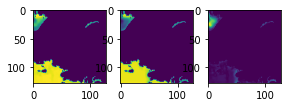

2.7008564


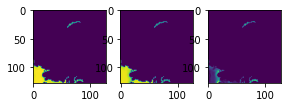

0.69115305


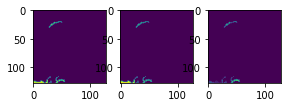

0.23623875


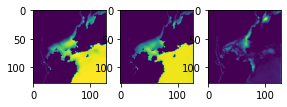

4.9549255


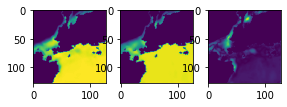

5.5375886


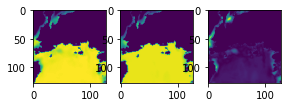

5.5463305


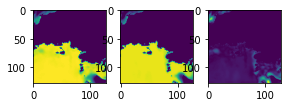

5.040495


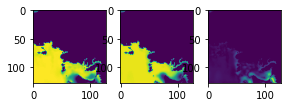

5.335043


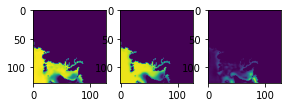

4.447674


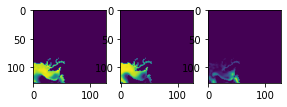

3.3219929


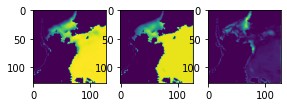

4.9185677


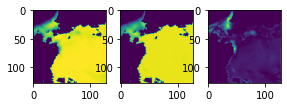

5.701604


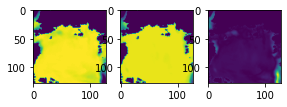

8.174939


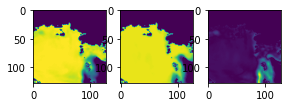

10.024009


In [ ]:
for i in range(BATCH_SIZE):
    plt.subplot(141)
    plt.imshow(next(iter(val_dataset))[1][i,0,:,:,0])
    plt.subplot(142)
    plt.imshow(pred[i,0,:,:,0])
    plt.subplot(143)
    plt.imshow(np.abs(next(iter(val_dataset))[1][i,0,:,:,0] - pred[i,0,:,:,0]))
    plt.show()
    print(np.mean(np.abs(next(iter(val_dataset))[1][i,0,:,:,0] - pred[i,0,:,:,0])))
    

# 2018년 추론 데이터 전처리

2013 ~ 2017년까지 5년간 월별 데이터를 학습과 같은 형태로 전처리

In [ ]:
x_test = train_month[:,-6:-1,:,:,:1]
x_test = np.swapaxes(x_test , 0, 1)

In [ ]:
x_test_set = []
for m in range(12):
    feature = []
    for i in range((x_train.shape[3]-feature_size)//stride+1):
        for j in range((x_train.shape[4]-feature_size)//stride+1):
            x_ = x_test[:, m, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, :1]/250
            feature.append(x_)
    feature = np.array(feature)
    x_test_set.append(feature)
x_test_set = np.array(x_test_set)

In [ ]:
x_test_set.shape

(12, 84, 5, 128, 128, 1)

# 추론

각 월별 추론하여 저장

In [ ]:
preds = []
for m in tqdm(range(12)):
    pred = model.predict(x_test_set[m])
    pred = np.where(pred>250, 250, pred)
    preds.append(pred)

100%|██████████| 12/12 [01:33<00:00,  7.78s/it]


# TTS

추론 결과 중복된 영역의 경우 평균을 이용해 앙상블

stride값이 작을 수록 앙상블에의해 결과가 좋아지나 일정값 이상으로 작아지면 큰 효과가 없고 추론시간이 기하급수적으로 늘어납니다.

In [ ]:
voting_mask = np.zeros((x_train.shape[-3], x_train.shape[-2]))
ones = np.ones((feature_size, feature_size))

for i in range((x_train.shape[3]-feature_size)//stride+1):
    for j in range((x_train.shape[4]-feature_size)//stride+1):
        voting_mask[stride*i:stride*i+feature_size, stride*j:stride*j+feature_size] += ones

평균 계산용 마스크

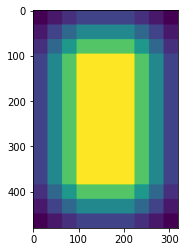

In [ ]:
plt.imshow(voting_mask)

In [ ]:
results = []
for m in range(12):
    pred = np.zeros((x_train.shape[-3], x_train.shape[-2]))
    k = 0
    for i in range((x_train.shape[3]-feature_size)//stride+1):
        for j in range((x_train.shape[4]-feature_size)//stride+1):
            pred[stride*i:stride*i+feature_size, stride*j:stride*j+feature_size] += preds[m][k,-1,:,:,0]
            k+=1
    pred /= voting_mask
    results.append(pred[:448, :304])
results = np.array(results)

# 추론 결과

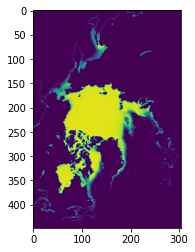

1 



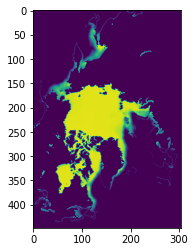

2 



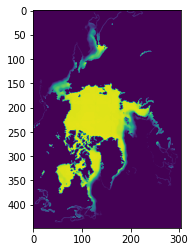

3 



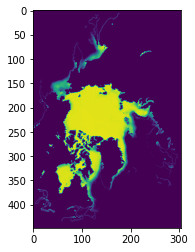

4 



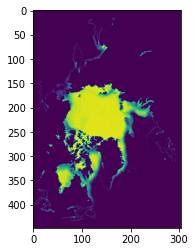

5 



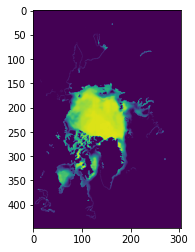

6 



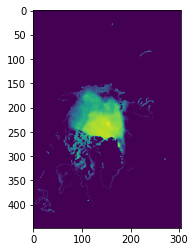

7 



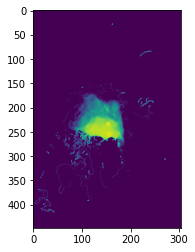

8 



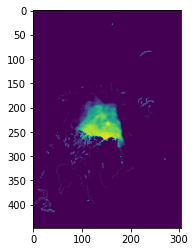

9 



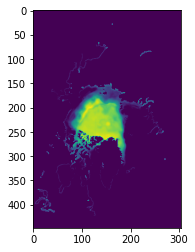

10 



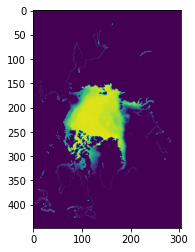

11 



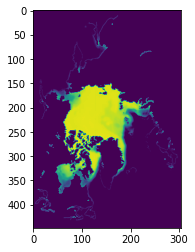

12 



In [ ]:
for m in range(12):
    plt.imshow(results[m])
    plt.show()
    print(m+1, '\n')

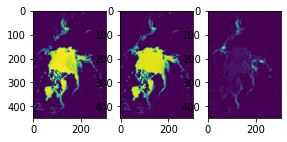

3.3597023646664956


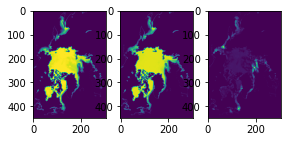

3.221268606777946


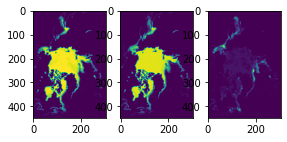

3.936213270338827


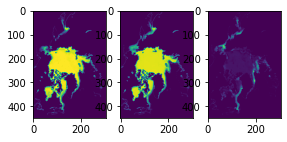

4.011242352841855


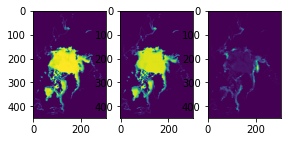

4.235263671803205


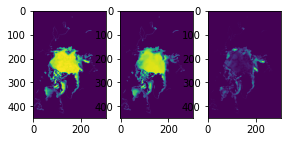

4.754317112625039


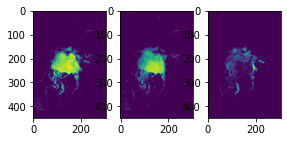

4.274540372379846


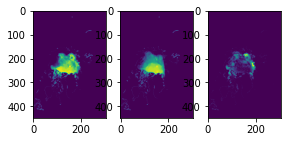

3.161096618731295


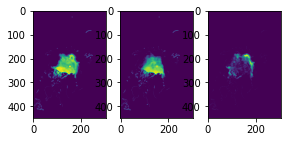

3.003700095965536


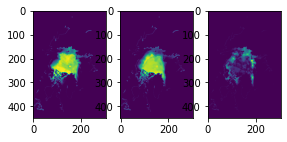

3.6513907143143425


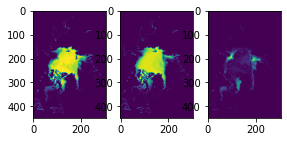

3.6914560168154877


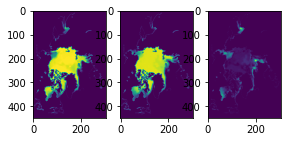

3.4401033705041666


In [ ]:
for i in range(12):
    plt.subplot(141)
    plt.imshow(train[348+i,:,:,0])
    plt.subplot(142)
    plt.imshow(results[i])
    plt.subplot(143)
    plt.imshow(np.abs(train[348+i,:,:,0] - results[i]))
    plt.show()
    print(np.mean(np.abs(train[348+i,:,:,0] - results[i])))
    

# 제출

In [ ]:
submission = pd.read_csv(path+'sample_submission.csv')
submission

submission의 값을 변경할 경우 시간이 오래걸려 추론 결과를 reshape하여 붙였습니다.

In [ ]:
sub_2019 = submission.loc[:11, ['month']].copy()
sub_2020 = submission.loc[12:].copy()

sub_2019 = pd.concat([sub_2019, (pd.DataFrame(results.reshape([12,-1])))], axis=1)
sub_2019.columns = submission.columns
submission = pd.concat([sub_2019, sub_2020])

In [ ]:
submission

결과 저장

In [ ]:
submission.to_csv('submission.csv', index=False)